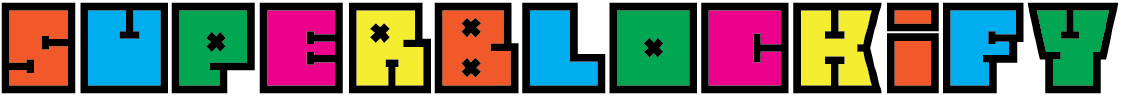

More info: [superblockify.city](https://superblockify.city)

# Network visualization
This notebook creates figures visualizing street networks with Superblocks and routing.

## 1. Build up

Build up animation for the graph representation.

Plot Ludgeri-Kreisel, Münster, Germany in the following steps:

1. Only base map
2. Add the nodes
3. Add the edges
4. Add the labels
   Edge coloring based on residential tag

In [ ]:
import contextily as ctx
import matplotlib.pyplot as plt
import osmnx as ox

In [ ]:
# Bounding box for the concerned area - north, south, east, west
# bbox finder: https://norbertrenner.de/osm/bbox.html
bbox = (51.95809, 51.95388, 7.63017, 7.6256)
buffer = 0.005
bbox_buffered = (bbox[0] + buffer, bbox[1] - buffer, bbox[2] + buffer, bbox[3] - buffer)

# Get the graph
G = ox.graph_from_bbox(*bbox_buffered, network_type='drive')

# Undirected graph
G = G.to_undirected()

# Project to CRS 3857
G = ox.project_graph(G, to_crs=3857)

In [ ]:
# To Geodataframe
nodes, edges = ox.graph_to_gdfs(G)
# Make bounding box from projected nodes
bbox_projected = nodes.total_bounds
# smaller bbox by zoom_factor
zoom_factor = 0.4
bbox_projected = (
    bbox_projected[0] + (bbox_projected[2] - bbox_projected[0]) * (1 - zoom_factor) / 2,
    bbox_projected[1] + (bbox_projected[3] - bbox_projected[1]) * (1 - zoom_factor) / 2,
    bbox_projected[2] - (bbox_projected[2] - bbox_projected[0]) * (1 - zoom_factor) / 2,
    bbox_projected[3] - (bbox_projected[3] - bbox_projected[1]) * (1 - zoom_factor) / 2)
# color edges by residential tag
edges['color'] = edges['highway'].apply(lambda x: str(x))

In [ ]:
def make_buildup_plot(source, node_alpha, edge_alpha, filename,
                      node_color='black', edge_color='cornflowerblue',
                      edge_column=None, edge_categorical=None):
    # Setup the figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 10))
    # set x and y limits
    ax.set_xlim(bbox_projected[0], bbox_projected[2])
    ax.set_ylim(bbox_projected[1], bbox_projected[3])

    # Add intersection nodes
    nodes.plot(ax=ax, markersize=45, color=node_color, zorder=3, alpha=node_alpha)

    # Add street edges
    edges.plot(ax=ax, linewidth=2.5, color=edge_color, zorder=1, alpha=edge_alpha,
               column=edge_column, categorical=edge_categorical)

    # Add base map
    ctx.add_basemap(ax, source=source)

    # Show the figure
    ax.set_axis_off()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

In [ ]:
make_buildup_plot(ctx.providers.OpenStreetMap.DE, 0.0, 0.0, 'buildup_ludgeri_0.pdf')
make_buildup_plot(ctx.providers.CartoDB.Positron, 1.0, 0.0, 'buildup_ludgeri_1.pdf')
make_buildup_plot(ctx.providers.CartoDB.Positron, 1.0, 1.0, 'buildup_ludgeri_2.pdf')
make_buildup_plot(ctx.providers.CartoDB.Positron, 1.0, 1.0, 'buildup_ludgeri_3.pdf',
                  edge_color=None, edge_column='color', edge_categorical=True)

## 2. Routing

Scheveningen, NL

1. Wide map with network and base map
2. Mark two nodes
3. Add shortest path
4. Sparsified network (edges with residential tag)
5. Shortest path on sparsified network

In [ ]:
import superblockify as sb

PLACE = ('Scheveningen',
         [
             'Scheveningen, The Hague, Netherlands',
             'Centrum, The Hague, Netherlands',
             # buffering, so we not only see Scheveningen
             'Haagse Hout, The Hague, Netherlands',
             'Segbroek, The Hague, Netherlands',
         ]
         )

In [ ]:
# This will open a data folder in the current directory
part = sb.ResidentialPartitioner(name="Scheveningen_Notebook",
                                 city_name=PLACE[0],
                                 search_str=PLACE[1],
                                 )
part.run(calculate_metrics=True, make_plots=False)
sb.save_to_gpkg(part, "Scheveningen_Notebook.gpkg")
part.save(save_graph_copy=True)

In [ ]:
part = sb.ResidentialPartitioner.load("Scheveningen_Notebook")
nodes, edges = ox.graph_to_gdfs(part.graph)
nodes, edges = ox.project_gdf(nodes, to_crs=3857), ox.project_gdf(edges, to_crs=3857)

In [ ]:
def reconstruct_path(pred, start, end):
    """Reconstruct path from predecessor matrix."""
    if start == end:
        return []
    prev = pred[start]
    curr = prev[end]
    path = [end, curr]
    while curr != start:
        curr = prev[curr]
        path.append(curr)
    return list(reversed(path))

In [ ]:
def make_routing_plot(filename,
                      pred_type=None, start_end_markers=False,
                      cmap=None,
                      node_alpha=0.0, edge_alpha=1.0,
                      node_color='black', edge_color=None,
                      edge_column=None, edge_categorical=None,
                      source=ctx.providers.CartoDB.Positron
                      ):
    # Setup the figure
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    # Add intersection nodes
    nodes.plot(ax=ax, markersize=2, color=node_color, zorder=3, alpha=node_alpha)

    # Add street edges
    edges.plot(ax=ax, linewidth=1, color=edge_color, zorder=1, alpha=edge_alpha,
               column=edge_column, categorical=edge_categorical, cmap=cmap)
    # plot sparsified edges over the original edges, where classification is SPARSE
    edges[edges['classification'] == 'SPARSE'].plot(ax=ax, linewidth=1,
                                                    color='black', zorder=2,
                                                    alpha=edge_alpha)

    # Routing
    from_id, to_id = 2192471779, 1434814616
    # osm ids are not stable, select in interactive map, next cell
    if start_end_markers:
        # Mark start and end node
        # start node as green flag pictogram
        nodes[nodes.index.isin([from_id])].plot(ax=ax, markersize=100,
                                                color='green', zorder=5,
                                                marker='^')
        # end node as red flag pictogram
        nodes[nodes.index.isin([to_id])].plot(ax=ax, markersize=100,
                                              color='darkred', zorder=5,
                                              marker='v')
    if pred_type in ["S", "N"]:
        # shortest path on original graph
        path_direct = reconstruct_path(part.metric.predecessor_matrix[pred_type],
                                       part.metric.node_list.index(from_id),
                                       part.metric.node_list.index(to_id))
        # translate to osm ids
        path_direct = [part.metric.node_list[i] for i in path_direct]
        # get edges of part.graph on the path
        path_edges = [(u, v, 0) for u, v in zip(path_direct[:-1], path_direct[1:])]
        # gdf of edges
        path_edges = ox.graph_to_gdfs(part.graph.edge_subgraph(path_edges), nodes=False)
        # project
        path_edges = ox.project_gdf(path_edges, to_crs=3857)
        # sum of lengths
        print(f"Length of shortest path: {path_edges['length'].sum():.2f} m")
        # plot the shortest path
        path_edges.plot(ax=ax, linewidth=3, color='crimson', zorder=4, alpha=1.0)

    # Add base map
    ctx.add_basemap(ax, source=source)

    # Set lims dependent on the current limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim(xlim[0] + (xlim[1] - xlim[0]) * 0.0,
                xlim[1] - (xlim[1] - xlim[0]) * 0.25)
    ax.set_ylim(ylim[0] + (ylim[1] - ylim[0]) * 0.45,
                ylim[1] - (ylim[1] - ylim[0]) * 0.0)
    # Show the figure
    ax.set_axis_off()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)


# Base map
make_routing_plot('routing_scheveningen_0.pdf', edge_alpha=0.0,
                  source=ctx.providers.OpenStreetMap.DE)

# Show start and end node
make_routing_plot('routing_scheveningen_1.pdf', edge_color='black',
                  start_end_markers=True, edge_alpha=0.5)

# Start and end with direct path
make_routing_plot('routing_scheveningen_2.pdf', start_end_markers=True,
                  pred_type="S", edge_alpha=0.5, edge_color='black')

# Residential roads colored
make_routing_plot('routing_scheveningen_3.pdf', start_end_markers=True,
                  edge_color='cornflowerblue', edge_alpha=0.5)

# Start and end with restricted path
make_routing_plot('routing_scheveningen_4.pdf', start_end_markers=True,
                  pred_type="N", edge_color='cornflowerblue', edge_alpha=0.5)

# Start and end with restricted path and classification
make_routing_plot('routing_scheveningen_5.pdf', start_end_markers=True,
                  pred_type="N", edge_column='classification', edge_alpha=1.0,
                  edge_categorical=True)

In [ ]:
# interactive folium map to find out node ids
nodes.explore()